The k parameter is extremely important in the KNN classifier model. 

To find the optimal value of k, we will use a simple brute-force strategy. Namely, we will try many values of k and evaluate each, settling for the one with the best prediction results.

In [1]:
import pandas as pd 
import numpy as np  
import random
from sklearn.model_selection import train_test_split  
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [1]:
# Data preparation
path = '/Users/Kassi/Desktop/voice-gender/voice.csv'
voice_data = pd.read_csv(path)
voice_data = voice_data.values

NameError: name 'pd' is not defined

In [3]:
voices = voice_data[:, :-1] 
labels = voice_data[:, -1:]

In [4]:
from sklearn.preprocessing import LabelEncoder
gender_encoder = LabelEncoder()
labels = gender_encoder.fit_transform(labels)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# randomly shuffle data
voices_tmp = []  
lables_tmp = []  
index_shuf = range(len(voices)) 
random.shuffle(index_shuf) 
for i in index_shuf:  
    voices_tmp.append(voices[i])  
    lables_tmp.append(labels[i])  
voices = np.array(voices_tmp)  
labels = np.array(lables_tmp) 

In [6]:
train_x, test_x, train_y, test_y = train_test_split(voices, labels, test_size=0.2)  

In [7]:
# Method 1:
# We use KNeighborsClassifier to implement the k-nearest neighbors vote.
error_rate = []
kvals = range(1,21)  # range of k parameters to test

for i in kvals:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x,train_y)
    pred_y_i = knn.predict(test_x)
    error_rate.append(np.mean(pred_y_i != test_y))

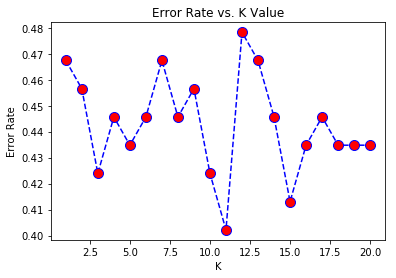

In [8]:
# Determine optimal value
# After evaluating many values of k, we can easily determine which value yields the best results. 
# The plot below visualizes our process.

plt.plot(kvals, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()


In [9]:
# Determine location of best performance
kloc = error_rate.index(min(error_rate))
print('Lowest error is %s occurs at k=%s.' % (error_rate[kloc], kvals[kloc]))

Lowest error is 0.402173913043 occurs at k=11.


/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


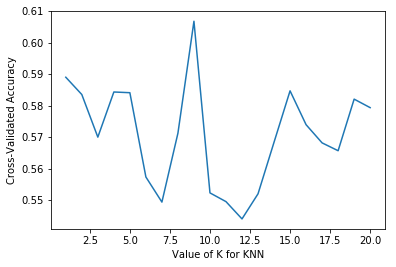

In [10]:
# We can also use cross_val_score to choose the best k value that can reach the highest accuracy
from sklearn.cross_validation import cross_val_score

k_range = range(1, 21)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_x, train_y, cv=10, scoring='accuracy') # for classification
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [11]:
# Determine location of best performance
kloc = k_scores.index(max(k_scores))
print('Highest accuracy is %s occurs at k=%s.' % (k_scores[kloc], k_range[kloc]))

Highest accuracy is 0.606764659396 occurs at k=9.


In [12]:
# Using our optimal k value, we will run the analysis again and proceed to quantify our classification accuracy.

from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=kvals[kloc])
knn.fit(train_x,train_y)
pred_y = knn.predict(test_x)

# Use classification metrics to determine success of method
# Run classification metrics
print('Accuracy in KNN:%s' % (accuracy_score(test_y, pred_y)) )
print('Confusion Matrix:')
print(confusion_matrix(test_y, pred_y))
print('\n')
print('Classification Report:')
print(classification_report(test_y, pred_y))

Accuracy in KNN:0.54347826087
Confusion Matrix:
[[25 19]
 [23 25]]


Classification Report:
             precision    recall  f1-score   support

          0       0.52      0.57      0.54        44
          1       0.57      0.52      0.54        48

avg / total       0.55      0.54      0.54        92



In [13]:
# Confusion matricies and classification reports are great ways to understand the accuracy of a classifier model. 
# This model does a poor job of classifying our data, scoring an average of %64 in all three categories.

In [14]:
# Method 2:
# We wrote our own method to implement the k-Nearest Neighbors algorithm from scratch.

import math
# Euclidean distance calculation
# In order to make predictions we calculate the similarity between any two given data instances. 
# This is needed so that we can locate the k most similar data instances in the training dataset for a given member of the test dataset and in turn make a prediction.
def calculateDistance(instance1, instance2,length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]),2)
    return math.sqrt(distance)


import operator
# Below is the getNeighbors function that returns k most similar neighbors 
# from the training set for a given test instance (using the already defined euclideanDistance function)

def getNeighbors(train_data, train_labels, test_data_single, num_of_input, k):
    distances = []
    length = num_of_input
    for x in range(len(train_data)):
        dist = calculateDistance(test_data_single, train_data[x],length)
        distances.append((train_data[x],train_labels[x],dist))
    distances.sort(key=operator.itemgetter(2))  #sort based on 3rd item which is distance
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][1])  #return top k nearest data's label
    return neighbors

from scipy.stats import mode


# The funuction below is used for getting the majority voted response from a number of neighbors.
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]
    

In [15]:
def KNN_Classifier(num_of_input):
    accuracy = []
    for K in range(1,20):
        results = []
        for i in range(len(test_x)):
            test_single = test_x[i]
            neighbor = getNeighbors(train_x, train_y, test_single, num_of_input, K)
            res = getResponse(neighbor)
            results.append(res)
        # We evaluate the accuracy of the model by calculating a ratio of the total correct predictions out of all predictions made (the classification accuracy)
        correct = 0
        wrong = 0
        for j in range(len(test_y)):
            if(results[j] == test_y[j]):
                correct += 1
            else:
                wrong += 1
        accuracy.append(float(correct)/(correct+wrong))
        print('Correct rate is %s when K = %s.'  % (float(correct)/(correct+wrong),K))
    print('Highest correct rate %s occurs at K = %s.' % (max(accuracy), accuracy.index(max(accuracy))+1))



In [16]:
KNN_Classifier(20)

Correct rate is 0.532608695652 when K = 1.
Correct rate is 0.54347826087 when K = 2.
Correct rate is 0.576086956522 when K = 3.
Correct rate is 0.554347826087 when K = 4.
Correct rate is 0.565217391304 when K = 5.
Correct rate is 0.554347826087 when K = 6.
Correct rate is 0.532608695652 when K = 7.
Correct rate is 0.554347826087 when K = 8.
Correct rate is 0.54347826087 when K = 9.
Correct rate is 0.576086956522 when K = 10.
Correct rate is 0.597826086957 when K = 11.
Correct rate is 0.521739130435 when K = 12.
Correct rate is 0.532608695652 when K = 13.
Correct rate is 0.554347826087 when K = 14.
Correct rate is 0.586956521739 when K = 15.
Correct rate is 0.565217391304 when K = 16.
Correct rate is 0.554347826087 when K = 17.
Correct rate is 0.565217391304 when K = 18.
Correct rate is 0.565217391304 when K = 19.
Highest correct rate 0.597826086957 occurs at K = 11.


In [17]:
# Is it enough of these two features to make predictions? 
## KNN with 2 features ('meanfun', 'IQR')

train_x = train_x[:,[5,12]]
test_x = test_x[:,[5,12]]
KNN_Classifier(2)

Correct rate is 0.815217391304 when K = 1.
Correct rate is 0.847826086957 when K = 2.
Correct rate is 0.880434782609 when K = 3.
Correct rate is 0.902173913043 when K = 4.
Correct rate is 0.880434782609 when K = 5.
Correct rate is 0.902173913043 when K = 6.
Correct rate is 0.902173913043 when K = 7.
Correct rate is 0.902173913043 when K = 8.
Correct rate is 0.902173913043 when K = 9.
Correct rate is 0.913043478261 when K = 10.
Correct rate is 0.913043478261 when K = 11.
Correct rate is 0.913043478261 when K = 12.
Correct rate is 0.913043478261 when K = 13.
Correct rate is 0.913043478261 when K = 14.
Correct rate is 0.913043478261 when K = 15.
Correct rate is 0.913043478261 when K = 16.
Correct rate is 0.913043478261 when K = 17.
Correct rate is 0.913043478261 when K = 18.
Correct rate is 0.913043478261 when K = 19.
Highest correct rate 0.913043478261 occurs at K = 10.


Conclusion: 

A k value that is too low will overfit the data, missing general trends that better distinguish the different classes. Conversely, a k value that is too high will underfit the data and lead to a classification model that creates loose and ill-defined boundaries around key features in the data field.

For our data set, the KNN method is not very successful in differentiating between male and female voices with all features, given the acoustic properties provided.

However, K-means result with only two features gives 91.3 % against 59.8% with all features. 